# MODELS TO BE ENSEMBLE

In [31]:
# #Setup Gdrive file download extention
!pip install gdown open-clip-torch faiss-gpu

In [32]:
!gdown --id 1BFAJfzzeaUGsPoYELS86HIutJ43D-vat

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1BFAJfzzeaUGsPoYELS86HIutJ43D-vat
From (redirected): https://drive.google.com/uc?id=1BFAJfzzeaUGsPoYELS86HIutJ43D-vat&confirm=t&uuid=65be034a-ec5b-41e8-8bef-a64d5d194c3b
To: /kaggle/working/model1.pt
100%|███████████████████████████████████████| 1.26G/1.26G [00:06<00:00, 200MB/s]


In [33]:
path1 = '/kaggle/working/model1.pt'

In [34]:
import os
import math

import numpy as np
 
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import open_clip

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torchvision.transforms as T

from tqdm import tqdm
import pandas as pd
import cv2
from PIL import Image
import time

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math
# import numpy as np
# import os
import faiss
import copy
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2




In [35]:
def get_similiarity_l2(embeddings_gallery, emmbeddings_query, k):
    print('Processing indices...')

    s = time.time()
    index = faiss.IndexFlatL2(embeddings_gallery.shape[1])
    index.add(embeddings_gallery)

    scores, indices = index.search(emmbeddings_query, k) 
    e = time.time()

    print(f'Finished processing indices, took {e - s}s')
    return scores, indices

In [36]:
def map_per_set(labels, predictions, k=5):
    return np.mean([map_per_image(l, p, k) for l,p in zip(labels, predictions)])

In [37]:
def map_per_image(label, predictions, k=5): 
    try:
        return 1 / (predictions[:k].index(label) + 1)
    except ValueError:
        return 0.0

In [38]:
def convert_indices_to_labels(indices, labels):
    indices_copy = copy.deepcopy(indices)
    for row in indices_copy:
        for j in range(len(row)):
            row[j] = labels[row[j]]
    return indices_copy

In [39]:
device = 'cuda' if th.cuda.is_available() else 'cpu';

# Reading Dataset

In [40]:

def read_image(image_file):
    img = cv2.imread(
        image_file, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is None:
        raise ValueError('Failed to read {}'.format(image_file))
    return img


class SubmissionDataset(Dataset):
    def __init__(self, root, annotation_file, transforms, with_bbox=False):
        self.root = root
        self.imlist = pd.read_csv(annotation_file)
        self.transforms = transforms
        self.with_bbox = with_bbox

    def __getitem__(self, index):
        cv2.setNumThreads(6)

        full_imname = os.path.join(self.root, self.imlist['img_path'][index])
        img = read_image(full_imname)

        if self.with_bbox:
            x, y, w, h = self.imlist.loc[index, 'bbox_x':'bbox_h']
            img = img[y:y+h, x:x+w, :]

        img = Image.fromarray(img)
        img = self.transforms(img)
        product_id = self.imlist['product_id'][index]
        return img, product_id

    def __len__(self):
        return len(self.imlist)

In [41]:
import numpy as np
import cv2

imgs_path = "/kaggle/input/vprtestdata/public_dataset/gallery/"

files = [imgs_path + x for x in os.listdir(imgs_path) if "jpg" in x]

# List of image paths
image_paths = files

# Calculate mean and std
mean = np.zeros(3)
std = np.zeros(3)
num_images = len(image_paths)

for image_path in image_paths:
    img = cv2.imread(image_path) / 255.0  # Read and normalize image
    mean += img.mean(axis=(0, 1))
    std += img.std(axis=(0, 1))

mean /= num_images
std /= num_images

print("Mean:", mean)
print("Std:", std)

Mean: [0.75410071 0.76879095 0.7930227 ]
Std: [0.25881864 0.25062647 0.23544936]


In [42]:
def get_transform():  
    transform = T.Compose([
            T.Resize(
                size=(224, 224), 
                interpolation=T.InterpolationMode.BICUBIC,
                antialias=True),
            T.ToTensor(), 
            T.Normalize(
                mean=(0.48145466, 0.4578275, 0.40821073), 
                std=(0.26862954, 0.26130258, 0.27577711)
            )
        ])
    return transform

@th.no_grad()
def get_feature_vector(model, dataloader, epoch=10, use_cuda=False):
    features = []
    product_id = []
    
    for imgs, p_id in tqdm(dataloader):
        if use_cuda:
            imgs = imgs.cuda()
        features.append(th.squeeze(model(imgs)).detach().cpu().numpy().astype(np.float32))
        product_id.append(th.squeeze(p_id).detach().cpu().numpy())

    return np.concatenate(features, axis=0), np.concatenate(product_id)

# Getting the CLIP model's embedding

In [43]:
backbone = open_clip.create_model_and_transforms('ViT-H-14', None)[0].visual
backbone.load_state_dict(th.load(path1))
# backbone.half()   # Apply half precision to the backbone model
backbone.eval()   # Dropping unecessary layers
model = backbone
# model.cuda()

In [44]:
transform = get_transform()

img_dir = "/kaggle/input/vprtestdata/public_dataset/"

dataset_train = SubmissionDataset(img_dir, os.path.join(img_dir, "gallery.csv"), transform)
dataloader_train = DataLoader(dataset_train, batch_size=512, num_workers=4)
dataset_test = SubmissionDataset(img_dir, os.path.join(img_dir, "queries.csv"), transform, with_bbox=True)
dataloader_test = DataLoader(dataset_test, batch_size=512, num_workers=4)

In [45]:
def predict(model):
    global feature_vectors_gallery
    
    feature_vectors_gallery, labels_gallery = get_feature_vector(model, dataloader_train, 1)
    feature_vectors_query, labels_query = get_feature_vector(model, dataloader_test, 1)
    
    _, indices = get_similiarity_l2(feature_vectors_gallery, feature_vectors_query, 1000)

    indices = indices.tolist()
    labels_gallery = labels_gallery.tolist()
    labels_query = labels_query.tolist()

    preds = convert_indices_to_labels(indices, labels_gallery)
    score = map_per_set(labels_query, preds)
    return [indices, score]

In [46]:
# feature_vectors_gallery.shape

In [47]:
# import numpy as np

# np.save('embedding/feature_vectors_gallery.npy', feature_vectors_gallery)

In [48]:
[preds, score] = predict(model)
print(f'Average mAP score is : {score}')

preds = pd.DataFrame(preds)
preds.to_csv('preds.csv', index=False)

  0%|          | 0/3 [03:25<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
preds.head()

# Getting Similar Products

In [49]:
def transform_img(image):
    img = image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if isinstance(img, np.ndarray):
        img =  Image.fromarray(img)
        
    img = transform(img)

    return img

In [50]:
@th.no_grad()
def get_feature_vector_img(model, imgs, epoch=10, use_cuda=False):
    features = []
    if use_cuda:
        imgs = imgs.cuda()
    x = (model(imgs)).detach().cpu().numpy().astype(np.float32)  # .half()
    features.append(x)

    return np.concatenate(features, axis=0)

In [51]:
img_path = '/kaggle/input/vprtestdata/public_dataset/queries/abiding-inchworm-of-ultimate-freedom.jpeg'

image = read_image(img_path)

image = transform_img(image)

image = image.unsqueeze(dim=0)

image.shape

torch.Size([1, 3, 224, 224])

In [52]:
feature_vectors_gallery = np.load('/kaggle/input/gallary-embedding/feature_vectors_gallery.npy')

In [53]:
feature_vectors_query = get_feature_vector_img(model, image, 1)

_, indices = get_similiarity_l2(feature_vectors_gallery, feature_vectors_query, 1000)

indices = indices.tolist()

similar_images = indices

Processing indices...
Finished processing indices, took 0.03897500038146973s


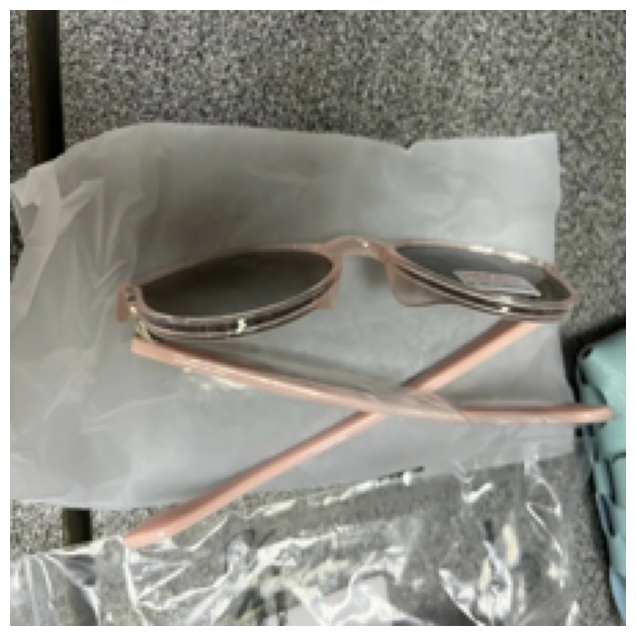

In [54]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(img_path)

img = img.resize((224, 224))

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

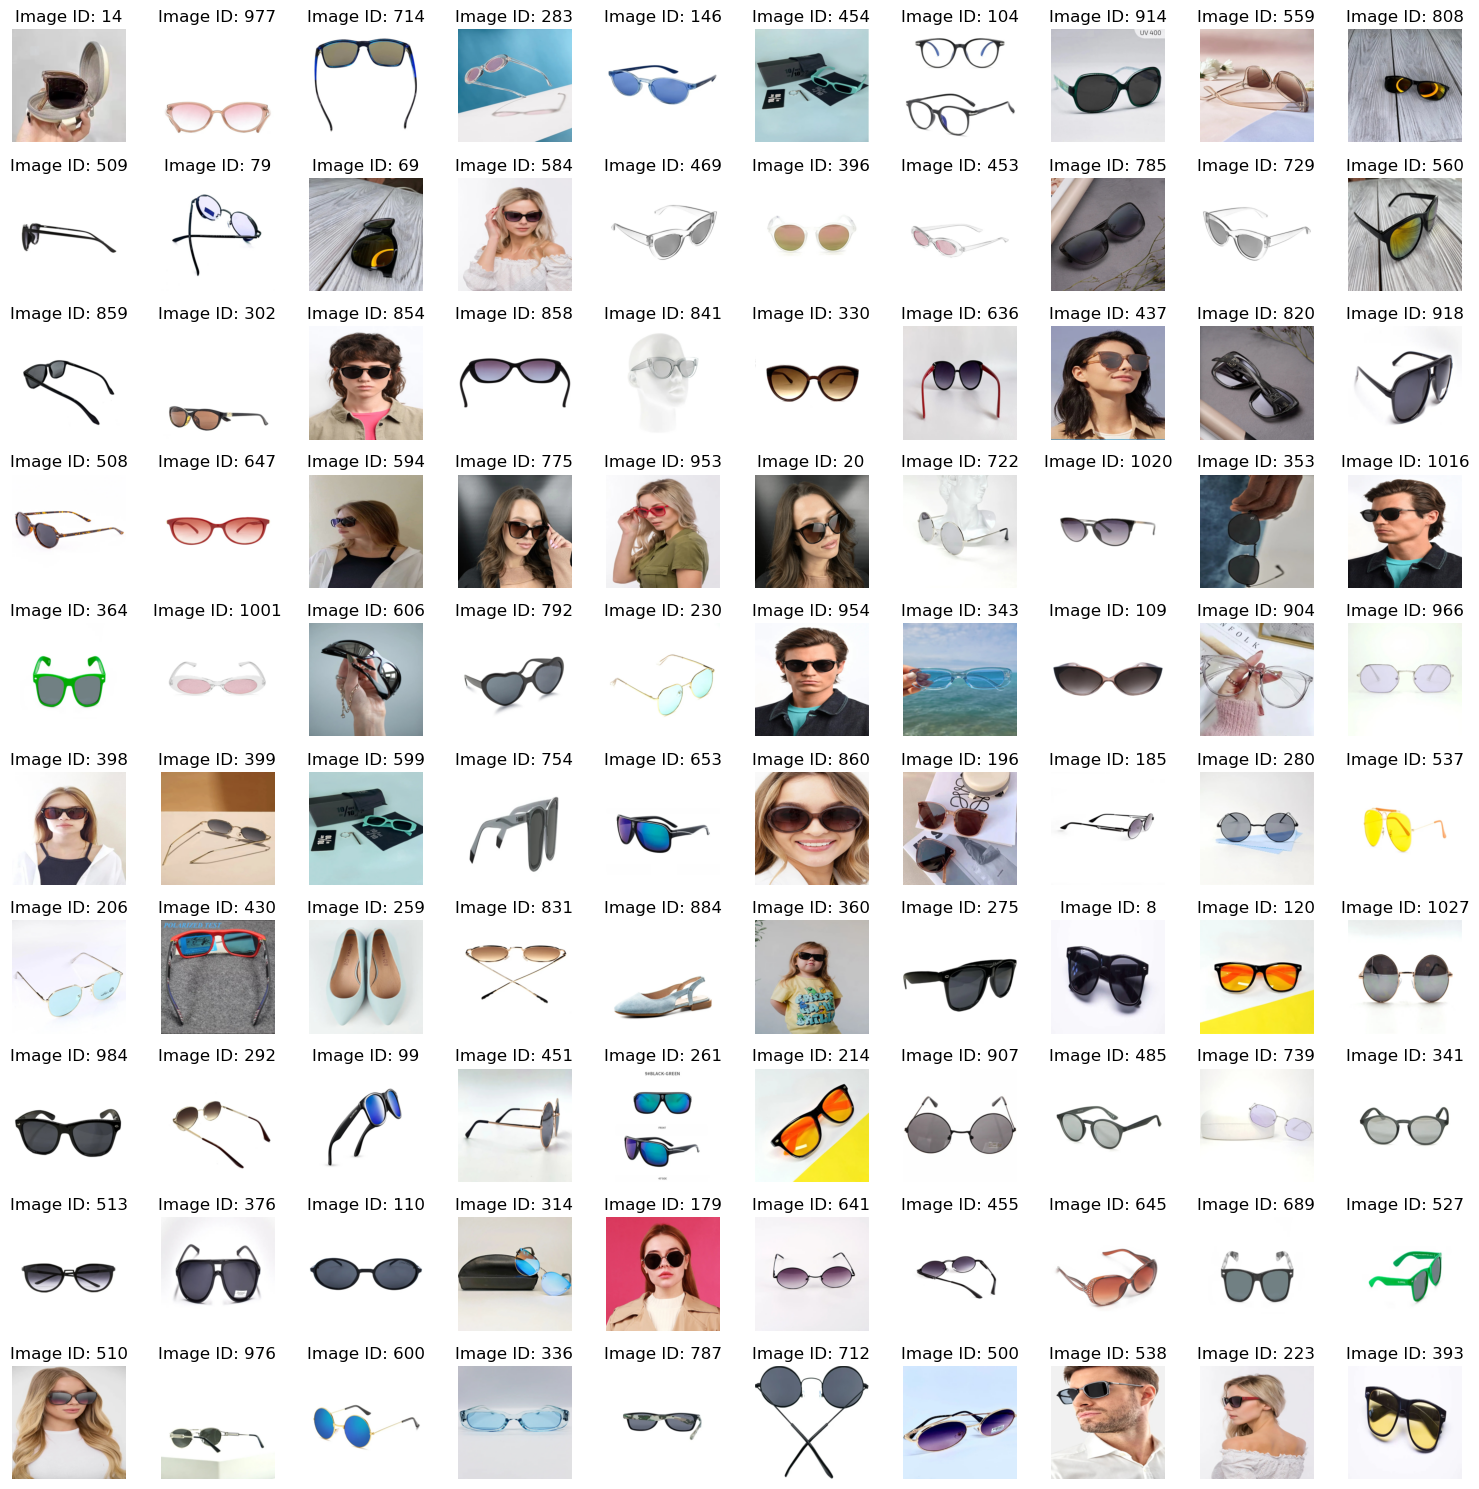

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

csv_path = '/kaggle/input/vprtestdata/public_dataset/gallery.csv'  # Replace with the actual path
data = pd.read_csv(csv_path)

prod_ids = similar_images[0][:100]  # Replace with your desired IDs

# Calculate the number of rows and columns for the subplots
num_images = len(prod_ids)
num_columns = 10
num_rows = (num_images + num_columns - 1) // num_columns

# Set up the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 15))

for i, prod_id in enumerate(prod_ids):
    row = data[data['seller_img_id'] == prod_id]
    
    if not row.empty:
        image_path = '/kaggle/input/vprtestdata/public_dataset/' + row.iloc[0]['img_path']
        img = Image.open(image_path)
        
        # Resize the image to 224x224
        img = img.resize((224, 224))
        
        # Calculate the subplot index
        row_idx = i // num_columns
        col_idx = i % num_columns
        
        ax = axes[row_idx, col_idx]
        ax.imshow(img)
        ax.set_title(f"Image ID: {prod_id}")
        ax.axis('off')

# Remove any empty subplots
for i in range(num_images, num_rows * num_columns):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [ ]:
# import zipfile
# import os



# def zip_folder(folder_path, zip_filename):
#     with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, _, files in os.walk(folder_path):
#             for file in files:
#                 file_path = os.path.join(root, file)
#                 arcname = os.path.relpath(file_path, folder_path)
#                 zipf.write(file_path, arcname)

# # Replace 'your_folder_path' with the actual path to the folder you want to zip
# folder_to_zip = '/kaggle/working/embedding'
# output_zip_path = 'gallary_embedding.zip'

# zip_folder(folder_to_zip, output_zip_path)

In [ ]:
# from IPython.display import FileLink

# # Display a download link for the zip file
# FileLink(output_zip_path)